# Анализ геоданных при помощи geopandas и shapely

In [ ]:
!pip install -q condacolab -q

import condacolab

condacolab.install()

✨🍰✨ Everything looks OK!


In [ ]:
!conda install geopandas

import geopandas as gpd

## Получаем данные о COVID-19

In [ ]:
import pandas as pd
#df_iso_codes = pd.read_html('https://ru.wikipedia.org/wiki/ISO_3166-2:RU')                  # получаем данные из интернета
#df_iso_codes[1:-1]                                                                          # обрезаем ненужное из данных
df_iso_codes = pd.concat(pd.read_html('https://ru.wikipedia.org/wiki/ISO_3166-2:RU')[1: -1]) # получаем DataFrame
df_iso_codes.columns = ['geocode', 'region', 'status']                                       # меняем названия колонок
iso_codes = df_iso_codes['geocode'].to_list() # можно и через unique()                       # получаем список кодов
iso_codes


Используем сервис с сайта [стопкорорнавирус.рф](https://xn--80aesfpebagmfblc0a.xn--p1ai/information/#) чтобы получить данные о заболеваемости и смертности за последний месяц

In [ ]:
pd.read_json('https://xn--80aesfpebagmfblc0a.xn--p1ai/covid_data.json?do=region_stats&code=RU-SPE')

,date,sick,healed,died,hospitalized,first,second
0,2022-02-20,1376809,1120169,31258,389,NaN,NaN
1,2022-02-19,1360210,1111026,31176,547,NaN,NaN


In [ ]:
# чтобы добраться до средств разработчика: щелкаем в браузере сверху справа <...>,
#                                                           Другие инструменты, Средсства разработчика(вылезет справа)
# щелкаем в верхней правой панели 'Сеть'
# выбираем слева строку 'СПб'
# в средсьвах разработчика появится строка 'covid_data.json?do=region_stats&code=RU-SPE' ее щелкаем и откроется вкладка с данными
from tqdm.notebook import tqdm # какой-то там бар
covid_data_list = [] # создаем пусой список для наполнения
for i in iso_codes: # создаем цикл, который добавит столбец с кодами регианов
                       # вместо iso_codes можно сделать tqdm(iso_codes) , тогда заработает tqdm
  df_covid_tmp = pd.read_json(f'https://xn--80aesfpebagmfblc0a.xn--p1ai/covid_data.json?do=region_stats&code={i}')
  # здесь {code} был вставлен вместо RU-SPE чтобы датафрейм был для всех регионов
  df_covid_tmp['region_iso'] = i
  covid_data_list.append(df_covid_tmp)
df_covid_data = pd.concat(covid_data_list)
df_covid_data

,date,sick,healed,died,hospitalized,first,second,region_iso
0,2022-02-20,78410.0,59582.0,711.0,80.0,NaN,NaN,RU-AMU
1,2022-02-19,76662.0,59468.0,709.0,131.0,NaN,NaN,RU-AMU
2,2022-02-18,75059.0,59365.0,708.0,142.0,516067.0,487263.0,RU-AMU
3,2022-02-17,73567.0,59286.0,708.0,143.0,NaN,NaN,RU-AMU
4,2022-02-16,72380.0,59205.0,708.0,176.0,NaN,NaN,RU-AMU
...,...,...,...,...,...,...,...,...
26,2022-01-25,12130.0,10981.0,447.0,11.0,NaN,NaN,RU-YEV
27,2022-01-24,12103.0,10979.0,445.0,3.0,NaN,NaN,RU-YEV
28,2022-01-23,12084.0,10979.0,443.0,0.0,NaN,NaN,RU-YEV
29,2022-01-22,12062.0,10976.0,442.0,13.0,NaN,NaN,RU-YEV


In [ ]:
df_covid_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2511 entries, 0 to 30
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          2511 non-null   datetime64[ns]
 1   sick          2511 non-null   float64       
 2   healed        2511 non-null   float64       
 3   died          2511 non-null   float64       
 4   hospitalized  2511 non-null   float64       
 5   first         405 non-null    float64       
 6   second        405 non-null    float64       
 7   region_iso    2511 non-null   object        
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 176.6+ KB


**Группируем значения как среднее за последний месяц**

In [ ]:
df_covid_mean = df_covid_data.groupby('region_iso')[
    [
    'sick',
    'healed',
    'died',
    'hospitalized'
    ]
].mean()
df_covid_mean

,sick,healed,died,hospitalized
region_iso,,,,
RU-AD,32786.032258,27400.741935,832.677419,53.806452
RU-ALT,154066.516129,116862.516129,7449.967742,278.064516
RU-AMU,63808.000000,57977.612903,679.774194,77.903226
RU-ARK,156908.903226,124968.064516,1566.387097,151.354839
RU-AST,93272.903226,82558.387097,2690.870968,99.451613
...,...,...,...,...
RU-VOR,238137.548387,201294.677419,7336.741935,249.419355
RU-YAN,84990.580645,66467.451613,988.548387,63.516129
RU-YAR,100479.677419,84257.612903,2149.645161,150.806452


**Расчитываем смертность и госпитализируемость относительно количества заболевших**


In [ ]:
df_covid_mean['mortality'] = df_covid_mean['died'] * 100 / df_covid_mean['sick']
df_covid_mean['hosp_per_100'] = df_covid_mean['hospitalized'] * 100 / df_covid_mean['sick']
df_covid_mean

,sick,healed,died,hospitalized,mortality,hosp_per_100
region_iso,,,,,,
RU-AD,32786.032258,27400.741935,832.677419,53.806452,2.539732,0.164114
RU-ALT,154066.516129,116862.516129,7449.967742,278.064516,4.835553,0.180483
RU-AMU,63808.000000,57977.612903,679.774194,77.903226,1.065343,0.122090
RU-ARK,156908.903226,124968.064516,1566.387097,151.354839,0.998278,0.096460
RU-AST,93272.903226,82558.387097,2690.870968,99.451613,2.884944,0.106624
...,...,...,...,...,...,...
RU-VOR,238137.548387,201294.677419,7336.741935,249.419355,3.080884,0.104738
RU-YAN,84990.580645,66467.451613,988.548387,63.516129,1.163127,0.074733
RU-YAR,100479.677419,84257.612903,2149.645161,150.806452,2.139383,0.150087


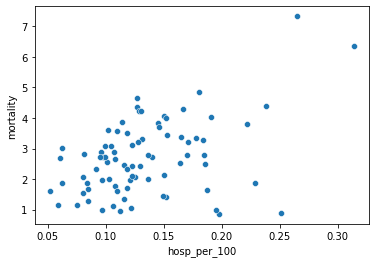

In [ ]:
import seaborn as sns
sns.scatterplot(data=df_covid_mean, y='mortality', x='hosp_per_100')

**## Обогащаем датасет при помощи геоданных**

In [ ]:
# import geopandas as gpd

df_regions = gpd.read_file('./regions.csv', geometry='way')

Основным столбцом в геодатафрейме является столбец geometry, содержащий в себе данные о геометриях. В исохдном файле иначе назван столбец с геометриями (way - это выгрузка из Open Street Maps). Way содержит в себе данные о геометриях в формате WKB (well known binary). Необходимо перевести эти данные в тип геометрий shapely и затем присвоить это значение для столбца geometry.

In [ ]:
from shapely import wkb
df_regions['geometry'] = df_regions['way'].apply(lambda x: wkb.loads(x, hex=True))
df_regions

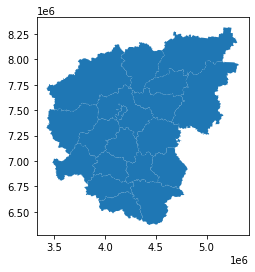

In [ ]:
df_regions.plot()

Теперь в столбце geometry мы можем увидеть данные в формате WKT (well known text). Это специализированный формат для географических данных, который представляет геометрии в виде серии точек с координатами. <br>
![map_01[1].jpg](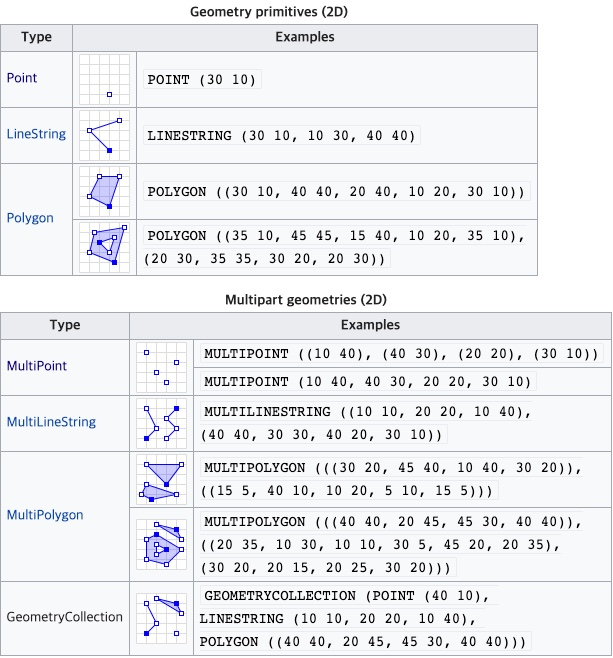)

Обратите внимание на то, что координаты в данном случае представлены не в привычном для нас формате "широты и долготы", а указаны в метрах. Это особенность проекции Pseudo-Mercator [SRID: 3857](https://epsg.io/3857). Мы можем в любой момент перевести геометрии в другую проекцию при помощи следующего кода

In [ ]:
df_regions = df_regions.set_crs(3857) # Задаем систему координат 3857
df_regions.to_crs(4326) # Переводим координаты в формат "долгота и широта"

,name,ref,way,geometry
0,Рязанская область,RU-RYA,0103000020110F000001000000BE000000F981EA071A1B...,"POLYGON ((42.63713 54.55780, 42.63729 54.55656..."
1,Воронежская область,RU-VOR,0103000020110F000001000000D310000000A2A3C5F831...,"POLYGON ((38.13775 51.63232, 38.13884 51.63147..."
2,Москва,RU-MOW,0103000020110F0000010000000A000000B98205D82B0C...,"POLYGON ((37.79003 56.00292, 37.79048 56.00248..."
3,Липецкая область,RU-LIP,0103000020110F000001000000830F0000E15ABC90BE04...,"POLYGON ((37.72172 52.60002, 37.72206 52.59761..."
4,Москва,RU-MOW,0103000020110F0000010000000F000000CDAAB36DB314...,"POLYGON ((37.86850 55.82378, 37.86894 55.82287..."
5,Тамбовская область,RU-TAM,0103000020110F000001000000F91300003B72C4AE40F3...,"POLYGON ((39.91569 52.70885, 39.92159 52.70844..."
6,Рязанская область,RU-RYA,0103000020110F00000200000014350000A97CEB59656B...,"POLYGON ((38.66598 54.25671, 38.67116 54.24705..."
7,Министерство транспорта Рязанской области,NULL,0103000020110F00000100000005000000E6FC27FA7AE1...,"POLYGON ((39.75221 54.62175, 39.75257 54.62152..."
8,Москва,RU-MOW,0103000020110F0000010000006A0000007DD5AAA22E12...,"POLYGON ((37.84533 55.81356, 37.84580 55.81324..."
9,Москва,RU-MOW,0103000020110F0000010000001200000041156AF04C0C...,"POLYGON ((37.79122 56.00729, 37.79311 56.00558..."


Особенностью формата WKT является то, что точки содержат в себе координаты Point(долгота широта), это связано с тем, что координаты точки в математической записи обычно указываются как (x; y).

Данные о регионах имеют серьезный недостаток: у каждой уникальной области может быть несколько геометрий. Хотелось бы их объединить таким образом, чтобы каждой области соответствовала своя геометрия. Это возможно сделать при помощи метода dissolve

In [ ]:
df_regions_trusted = df_regions.dissolve(by='ref')
df_regions_trusted

,geometry,name,way
ref,,,
NULL,"POLYGON ((4425195.909 7288798.187, 4425236.273...",Министерство транспорта Рязанской области,0103000020110F00000100000005000000E6FC27FA7AE1...
RU-BEL,"POLYGON ((3932437.422 6611880.132, 3933120.712...",Белгородская область,0103000020110F0000010000006B130000372403B68A00...
RU-BRY,"MULTIPOLYGON (((3510519.921 6888495.770, 35122...",Брянская область,0103000020110F00000100000015000000C1B68227F6C7...
RU-IVA,"POLYGON ((4383097.705 7723409.027, 4383457.667...",Ивановская область,0103000020110F000001000000301C0000F03D1B6D5EB8...
RU-KLU,"POLYGON ((3722678.762 7180524.435, 3722693.379...",Калужская область,0103000020110F0000010000007F3C0000D58A9161DB66...
RU-KOS,"POLYGON ((4496205.677 7842055.772, 4496455.088...",Костромская область,0103000020110F00000100000016290000BA6D506BD326...
RU-KRS,"POLYGON ((3793793.015 6739983.141, 3793812.340...",Курская область,0103000020110F000001000000361D000075ABE581C0F1...
RU-LIP,"POLYGON ((4199162.261 6909351.683, 4199199.988...",Липецкая область,0103000020110F000001000000830F0000E15ABC90BE04...
RU-MOS,"POLYGON ((3912712.621 7549960.015, 3912744.525...",Московская область,0103000020110F00000A0000009B4D000063CC834F04DA...


In [ ]:
df_hospitals = gpd.read_file('./hospitals.csv')
df_hospitals['geometry'] = df_hospitals['way'].apply(lambda x: wkb.loads(x, hex=True))
df_hospitals

,name,amenity,way,geometry
0,Туберкулёзный диспансер,hospital,0103000020110F000001000000050000004A14662331DD...,"POLYGON ((4682948.553 6686526.606, 4682950.312..."
1,Диспансер кожно-венерологический,hospital,0103000020110F000001000000090000004C84DA8E47DD...,"POLYGON ((4683038.232 6686056.450, 4683038.800..."
2,NULL,hospital,0103000020110F00000100000008000000CCDAE431C78A...,"POLYGON ((4598556.780 6740479.195, 4598582.439..."
3,Детское отделение,hospital,0103000020110F000001000000090000005DABDCB7369B...,"POLYGON ((4615386.873 6772770.997, 4615406.788..."
4,NULL,hospital,0103000020110F00000100000007000000FB938DF3189B...,"POLYGON ((4615267.806 6772964.123, 4615284.726..."
...,...,...,...,...
3175,Медпункт,hospital,0103000020110F00000100000005000000E5BCD1B4A705...,"POLYGON ((4724382.825 6762056.063, 4724391.185..."
3176,NULL,hospital,0103000020110F00000100000009000000D5069F85F606...,"POLYGON ((4725722.088 6774180.725, 4725722.210..."
3177,NULL,hospital,0103000020110F000001000000090000007BA64AB0B906...,"POLYGON ((4725478.755 6774071.377, 4725564.471..."
3178,Центральная районная больница,hospital,0103000020110F000001000000090000002534BE24DADD...,"POLYGON ((4683624.574 6688675.216, 4683633.246..."


Нет необходимости оставлять полигоны для больниц. Можно оставить только их точки-центроиды.

In [ ]:
df_hospitals['geometry'] = df_hospitals['geometry'].apply(lambda x: x.centroid).set_crs(3857)
df_hospitals['geometry']

0       POINT (4682977.697 6686516.077)
1       POINT (4683067.938 6686043.924)
2       POINT (4598646.978 6740455.633)
3       POINT (4615423.404 6772782.399)
4       POINT (4615313.438 6772950.539)
                     ...               
3175    POINT (4724393.947 6762055.757)
3176    POINT (4725735.916 6774148.537)
3177    POINT (4725531.079 6774077.871)
3178    POINT (4683778.846 6688424.108)
3179    POINT (4684564.173 6686249.912)
Name: geometry, Length: 3180, dtype: geometry

**Также мы можем расчитать центроиды и для регионов. На их основе мы можем расчитать расстояния до центра геометрии.**

In [ ]:
df_regions_trusted['centroid'] = df_regions_trusted['geometry'].apply(lambda x: x.centroid)
df_regions_trusted['centroid']

ref
NULL      POINT (4425226.622 7288786.199)
RU-BEL    POINT (4173233.333 6563927.041)
RU-BRY    POINT (3720680.976 6967579.573)
RU-IVA    POINT (4626143.625 7758696.799)
RU-KLU    POINT (3946278.376 7242557.789)
RU-KOS    POINT (4875869.047 8066123.374)
RU-KRS    POINT (4019130.303 6743150.660)
RU-LIP    POINT (4358145.366 6918698.904)
RU-MOS    POINT (4191544.036 7495270.882)
RU-MOW    POINT (4159375.957 7471462.334)
RU-NIZ    POINT (4967455.248 7627146.884)
RU-ORL    POINT (4060832.357 6943493.927)
RU-RYA    POINT (4522685.803 7235098.443)
RU-SMO    POINT (3673797.909 7355790.921)
RU-TAM    POINT (4629300.242 6925880.549)
RU-TUL    POINT (4182819.304 7150208.136)
RU-TVE    POINT (3865424.813 7783218.672)
RU-VLA    POINT (4527863.454 7562192.795)
RU-VOR    POINT (4478675.439 6618467.228)
RU-YAR    POINT (4357597.213 7941701.734)
Name: centroid, dtype: geometry

**Можно произвести пространственное объединение двух геодатафреймов: к данным о больницах добавить данные о регионе. **

In [ ]:
df_combined = gpd.sjoin(df_hospitals, df_regions_trusted, how='left', predicate='within') # Within - геометрия hospital находится внути геометрии region
df_combined

,name_left,amenity,way_left,geometry,index_right,name_right,way_right,centroid
0,Туберкулёзный диспансер,hospital,0103000020110F000001000000050000004A14662331DD...,POINT (4682977.697 6686516.077),RU-VOR,Воронежская область,0103000020110F000001000000D310000000A2A3C5F831...,POINT (4478675.439 6618467.228)
1,Диспансер кожно-венерологический,hospital,0103000020110F000001000000090000004C84DA8E47DD...,POINT (4683067.938 6686043.924),RU-VOR,Воронежская область,0103000020110F000001000000D310000000A2A3C5F831...,POINT (4478675.439 6618467.228)
2,NULL,hospital,0103000020110F00000100000008000000CCDAE431C78A...,POINT (4598646.978 6740455.633),RU-VOR,Воронежская область,0103000020110F000001000000D310000000A2A3C5F831...,POINT (4478675.439 6618467.228)
3,Детское отделение,hospital,0103000020110F000001000000090000005DABDCB7369B...,POINT (4615423.404 6772782.399),RU-TAM,Тамбовская область,0103000020110F000001000000F91300003B72C4AE40F3...,POINT (4629300.242 6925880.549)
4,NULL,hospital,0103000020110F00000100000007000000FB938DF3189B...,POINT (4615313.438 6772950.539),RU-TAM,Тамбовская область,0103000020110F000001000000F91300003B72C4AE40F3...,POINT (4629300.242 6925880.549)
...,...,...,...,...,...,...,...,...
3175,Медпункт,hospital,0103000020110F00000100000005000000E5BCD1B4A705...,POINT (4724393.947 6762055.757),RU-TAM,Тамбовская область,0103000020110F000001000000F91300003B72C4AE40F3...,POINT (4629300.242 6925880.549)
3176,NULL,hospital,0103000020110F00000100000009000000D5069F85F606...,POINT (4725735.916 6774148.537),RU-TAM,Тамбовская область,0103000020110F000001000000F91300003B72C4AE40F3...,POINT (4629300.242 6925880.549)
3177,NULL,hospital,0103000020110F000001000000090000007BA64AB0B906...,POINT (4725531.079 6774077.871),RU-TAM,Тамбовская область,0103000020110F000001000000F91300003B72C4AE40F3...,POINT (4629300.242 6925880.549)
3178,Центральная районная больница,hospital,0103000020110F000001000000090000002534BE24DADD...,POINT (4683778.846 6688424.108),RU-VOR,Воронежская область,0103000020110F000001000000D310000000A2A3C5F831...,POINT (4478675.439 6618467.228)


**Теперь мы можем найти расстояния между центроидами больниц и регионов. **

In [ ]:
df_combined['geodesic_distance'] = df_combined.distance(df_combined['centroid'])
df_combined['geodesic_distance']

0       215337.080938
1       215274.020151
2       171097.461065
3       153725.762753
4       153568.286102
            ...      
3175    189423.797758
3176    179784.433572
3177    179734.323231
3178    216705.728888
3179    216759.459336
Name: geodesic_distance, Length: 3180, dtype: float64

Рассчитаем количество больниц и среднее расстояние до геометрического центра области

In [ ]:
df_counts = df_combined.groupby(['index_right']).agg({'amenity': 'count', 'geodesic_distance': 'mean'})
df_counts

,amenity,geodesic_distance
index_right,,
RU-BEL,85,114441.882133
RU-BRY,130,125900.913010
RU-IVA,124,82335.913648
RU-KLU,72,124658.288658
RU-KOS,65,273769.508613
RU-KRS,249,92221.941795
RU-LIP,117,72954.193329
RU-MOS,562,97158.013178
RU-MOW,769,47843.022376


Объединим эти данные вместе с данными о заболеваемости и с геометриями регионов

In [ ]:
df_covid_result = pd.merge(
    df_covid_mean,
    df_counts,
    right_index=True,
    left_index=True,
    how='inner',
    validate='1:1'
)
df_covid_geo = pd.merge(
    df_covid_result,
    df_regions_trusted[['geometry', 'name', 'centroid']],
    right_index=True,
    left_index=True,
    how='inner',
    validate='1:1'
)
df_covid_geo = gpd.GeoDataFrame(df_covid_geo)
df_covid_geo

,sick,healed,died,hospitalized,mortality,hosp_per_100,amenity,geodesic_distance,geometry,name,centroid
RU-BEL,8.865997e+04,7.945327e+04,1911.466667,86.200000,2.155952,0.097225,85,114441.882133,"POLYGON ((3932437.422 6611880.132, 3933120.712...",Белгородская область,POINT (4173233.333 6563927.041)
RU-BRY,1.067326e+05,9.750027e+04,3217.000000,82.133333,3.014074,0.076952,130,125900.913010,"MULTIPOLYGON (((3510519.921 6888495.770, 35122...",Брянская область,POINT (3720680.976 6967579.573)
RU-IVA,7.292410e+04,6.329650e+04,2696.533333,65.833333,3.697726,0.090277,124,82335.913648,"POLYGON ((4383097.705 7723409.027, 4383457.667...",Ивановская область,POINT (4626143.625 7758696.799)
RU-KLU,7.265853e+04,6.423997e+04,1291.666667,74.000000,1.777722,0.101846,72,124658.288658,"POLYGON ((3722678.762 7180524.435, 3722693.379...",Калужская область,POINT (3946278.376 7242557.789)
RU-KOS,5.331140e+04,4.845757e+04,1168.233333,34.533333,2.191339,0.064777,65,273769.508613,"POLYGON ((4496205.677 7842055.772, 4496455.088...",Костромская область,POINT (4875869.047 8066123.374)
RU-KRS,8.771673e+04,8.117473e+04,2173.900000,87.800000,2.478318,0.100095,249,92221.941795,"POLYGON ((3793793.015 6739983.141, 3793812.340...",Курская область,POINT (4019130.303 6743150.660)
RU-LIP,9.369453e+04,8.277953e+04,3027.366667,73.200000,3.231103,0.078126,117,72954.193329,"POLYGON ((4199162.261 6909351.683, 4199199.988...",Липецкая область,POINT (4358145.366 6918698.904)
RU-MOS,7.572135e+05,6.385885e+05,13272.633333,595.200000,1.752826,0.078604,562,97158.013178,"POLYGON ((3912712.621 7549960.015, 3912744.525...",Московская область,POINT (4191544.036 7495270.882)
RU-MOW,2.326905e+06,1.986779e+06,38871.333333,1117.200000,1.670517,0.048012,769,47843.022376,"MULTIPOLYGON (((4108701.216 7424205.214, 41087...",Москва,POINT (4159375.957 7471462.334)
RU-NIZ,2.580978e+05,2.287335e+05,10483.733333,320.333333,4.061922,0.124113,1,184081.980520,"POLYGON ((4650536.113 7381034.428, 4651355.325...",Нижегородская область,POINT (4967455.248 7627146.884)


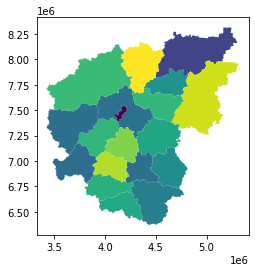

In [ ]:
df_covid_geo.plot(column='hosp_per_100')

In [ ]:
from shapely import wkt
df_covid_geo['long_lat_centroid'] = df_covid_geo['centroid'].to_crs(4326).astype('string')
df_covid_geo['long_lat_shape'] = df_covid_geo['geometry'].to_crs(4326).astype('string')
df_covid_geo.drop(columns=['centroid', 'geometry']).to_csv('kepler_data.csv')

geopandas.geodataframe.GeoDataFrame